In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import urllib.request
import xml.etree.ElementTree as ET
import psycopg2
import seaborn as sns
from datetime import datetime
from pymongo import MongoClient

In [92]:
# Connecting to MongoDB
mongo_client = MongoClient("mongodb://localhost:27017/")
project_db = mongo_client["projectdb"]

In [93]:
# Reading unemployment-statistics data
unemployment_statistics_url = "https://data.ny.gov/api/views/dh9m-5v4d/rows.json?accessType=DOWNLOAD"
unemployment_statistics_response = urllib.request.urlopen(unemployment_statistics_url)
unemployment_statistics_data = json.loads(unemployment_statistics_response.read())

# inserting into mongoDB
unemployment_statistics_collection = project_db["unemployment_statistics"]
# deleting extising data
unemployment_statistics_collection.drop()

cols = unemployment_statistics_data["meta"]["view"]["columns"]
cols_without_minus_one = filter(lambda val: val["id"] != -1, cols)
unemployment_statistics_cols = list(cols_without_minus_one)

unemployment_statistics_cols_others_len = len(list(filter(lambda val: val["id"] == -1, cols)))

for row in unemployment_statistics_data["data"]:
    db_row = {}
    for col_meta in unemployment_statistics_cols:
        data_value_index = int(col_meta["position"]) + unemployment_statistics_cols_others_len - 1
        db_row[col_meta["fieldName"]] = row[data_value_index]
    unemployment_statistics_collection.insert_one(db_row)

print("Inserted unemployment_statistics document count: ", unemployment_statistics_collection.count_documents({}))

Inserted unemployment_statistics document count:  1689


In [94]:
# Reading covid_cases
covid_cases_url = "https://data.cityofnewyork.us/api/views/rc75-m7u3/rows.json?accessType=DOWNLOAD"
covid_cases_response = urllib.request.urlopen(covid_cases_url)
covid_cases_data = json.loads(covid_cases_response.read())

# inserting into mongoDB
covid_cases_collection = project_db["covid_cases"]
# deleting extising data
covid_cases_collection.drop()


covid_cases_cols = list(filter(lambda val: val["id"] != -1, covid_cases_data["meta"]["view"]["columns"]))
covid_cases_cols_others_len = len(list(filter(lambda val: val["id"] == -1, covid_cases_data["meta"]["view"]["columns"])))


for row in covid_cases_data["data"]:
    db_row = {}
    for col in covid_cases_cols:
        db_row[col["fieldName"].lower()] = row[int(col["position"]) + covid_cases_cols_others_len - 1]
    covid_cases_collection.insert_one(db_row)

print("Inserted covid_cases document count: ",covid_cases_collection.count_documents({}))

Inserted covid_cases document count:  1019


In [95]:
# Reading air_quality
air_quality_url = "https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.xml?accessType=DOWNLOAD"
air_quality_response = urllib.request.urlopen(air_quality_url)
air_quality_xml = ET.parse(air_quality_response)
air_quality_xml_root = air_quality_xml.getroot()
air_quality_data = []

# inserting into mongoDB
air_quality_collection = project_db["air_quality"]
# deleting extising data
air_quality_collection.drop()

for row in air_quality_xml_root[0].findall('row'):
    air_quality_data_row = {}
    for elem in row.iter():
        if elem is not row:
            key = elem.tag.lower()
            value = elem.text
            #{"key":"value"}             
            air_quality_data_row[key] = value
    if len(air_quality_data_row) != 0:
        air_quality_collection.insert_one(air_quality_data_row)
print("Inserted air_quality document count: ", air_quality_collection.count_documents({}))

Inserted air_quality document count:  16122


In [96]:
#  MongoDB collections
# 1. unemployment_statistics_collection
# 2. covid_cases_collection
# 3. air_quality_collection

In [97]:
# creating table in postgress
conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="admin",
                        port="5432")

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS unemployment_statistics;CREATE TABLE unemployment_statistics (unemployment_statistics_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, area VARCHAR(255), labor_force BIGINT, employed BIGINT, unemployed BIGINT, unemployment_rate REAL);")
cursor.execute("DROP TABLE IF EXISTS covid_cases;CREATE TABLE covid_cases (covid_cases_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, case_count INTEGER);")
cursor.execute("DROP TABLE IF EXISTS air_quality;CREATE TABLE air_quality (air_quality_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, data_value REAL);")

conn.commit()

In [98]:
unemployment_statistics_collection = project_db["unemployment_statistics"]
query = """INSERT INTO unemployment_statistics 
    (date_of_interest, area, labor_force, employed, unemployed, unemployment_rate) 
    VALUES (%s,%s,%s,%s,%s,%s)"""
cursor = conn.cursor()
for row in unemployment_statistics_collection.find():
    date = row["year"]+"-"+row["month"]+"-01"
    cursor.execute(query, (date, row["area"], row["labor_force"], row["employed"], 
                           row["unemployed"], row["unemployment_rate"]))
cursor.close()
conn.commit()

In [99]:
covid_cases_collection = project_db["covid_cases"]

cursor = conn.cursor()
for row in covid_cases_collection.find():
    date = row["date_of_interest"]
    cursor.execute("INSERT INTO covid_cases (date_of_interest, case_count) VALUES (%s,%s)", 
                   (date, row["case_count"]))
cursor.close()
conn.commit()

In [100]:
air_quality_collection = project_db["air_quality"]

cursor = conn.cursor()
for row in air_quality_collection.find():
    date = row["start_date"]
    cursor.execute("INSERT INTO air_quality (date_of_interest, data_value) VALUES (%s,%s)", 
                   (date, row["data_value"]))
cursor.close()
conn.commit()

In [101]:
cursor = conn.cursor();
query = """
SELECT date_of_interest, AVG(unemployment_rate)
    FROM unemployment_statistics 
    WHERE date_of_interest >= '2020-01-01' and date_of_interest < '2022-01-01'
    GROUP BY date_of_interest ORDER BY date_of_interest ASC 

"""

    
cursor.execute(query)
unemployment_rate_data = cursor.fetchall()
cursor.close()


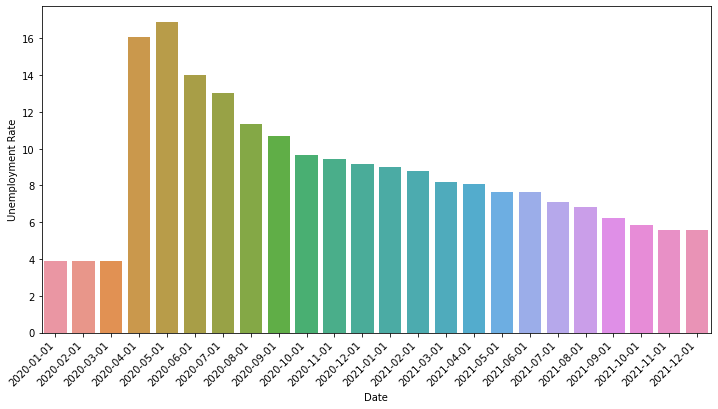

In [102]:

unemployment_rate_df = pd.DataFrame(data = unemployment_rate_data,
                                   columns=["Date",
                                            "Unemployment Rate"])


fig, ax = plt.subplots(figsize = (12,6))

fig = sns.barplot(
    data=unemployment_rate_df, 
    x="Date", 
    y="Unemployment Rate",
    ax=ax
)

x_dates = unemployment_rate_df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
arr = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


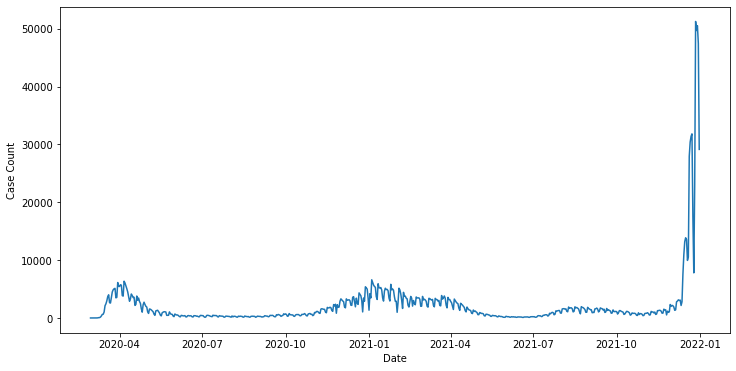

In [103]:
cursor = conn.cursor();
cursor.execute("""SELECT date_of_interest, avg(case_count) 
    FROM covid_cases  
    WHERE date_of_interest >= '2020-01-01' and date_of_interest < '2022-01-01'
    group by date_of_interest order by date_of_interest asc""")
covid_cases_data = cursor.fetchall()
cursor.close()


covid_cases_data_df = pd.DataFrame(data = covid_cases_data,
                                   columns=["Date",
                                            "Case Count"])

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(data = covid_cases_data_df, 
                   x="Date", 
                   y="Case Count",
                   ax=ax
                  )



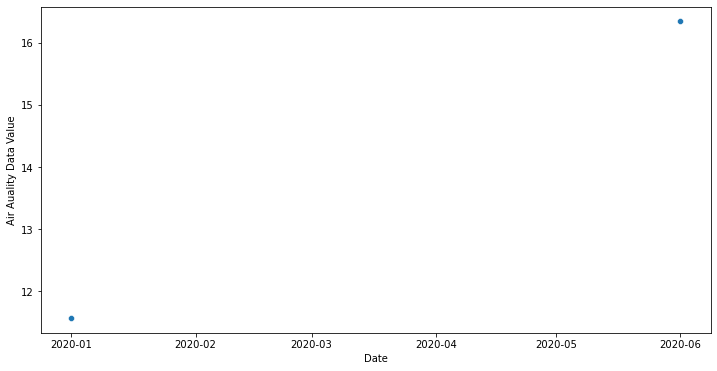

In [104]:
cursor = conn.cursor();
query = """
SELECT date_of_interest, avg(data_value) 
    FROM air_quality
    WHERE date_of_interest >= '2020-01-01' and date_of_interest < '2022-01-01'
    GROUP BY  date_of_interest order by date_of_interest asc
"""
cursor.execute(query)
air_quality_data = cursor.fetchall()
cursor.close()


air_quality_data_df = pd.DataFrame(data = air_quality_data,
                                   columns=["Date",
                                            "Air Auality Data Value"])

# print(air_quality_data_df)
fig, ax = plt.subplots(figsize = (12,6))

fig = sns.scatterplot(data = air_quality_data_df, x="Date", y="Air Auality Data Value", ax=ax)


In [105]:
unemployment_rate_df.head()

,Date,Unemployment Rate
0,2020-01-01,3.866667
1,2020-02-01,3.866667
2,2020-03-01,3.866667
3,2020-04-01,16.066667
4,2020-05-01,16.900000


In [106]:
covid_cases_data_df.head()

,Date,Case Count
0,2020-02-29,1.00000000000000000000
1,2020-03-01,0E-20
2,2020-03-02,0E-20
3,2020-03-03,1.00000000000000000000
4,2020-03-04,5.0000000000000000


In [107]:
air_quality_data_df.head()

,Date,Air Auality Data Value
0,2020-01-01,11.567340
1,2020-06-01,16.343664


In [110]:
covid_cases_air_quality_df = pd.merge(air_quality_data_df, covid_cases_data_df, how="outer", on ="Date")
all_data = pd.merge(covid_cases_air_quality_df, unemployment_rate_df, how="left", on ="Date")

all_data["Air Auality Data Value"] = all_data["Air Auality Data Value"].fillna(0)
all_data["Covid Case Count"] = all_data["Case Count"].fillna(0)
all_data["Unemployment Rate"] = all_data["Unemployment Rate"].fillna(0)

print(all_data)


          Date  Air Auality Data Value              Case Count  \
0   2020-01-01               11.567340                     NaN   
1   2020-06-01               16.343664    686.0000000000000000   
2   2020-02-29                0.000000  1.00000000000000000000   
3   2020-03-01                0.000000                   0E-20   
4   2020-03-02                0.000000                   0E-20   
..         ...                     ...                     ...   
668 2021-12-27                0.000000      51252.000000000000   
669 2021-12-28                0.000000      49689.000000000000   
670 2021-12-29                0.000000      50514.000000000000   
671 2021-12-30                0.000000      47460.000000000000   
672 2021-12-31                0.000000      29141.000000000000   

     Unemployment Rate        Covid Case Count  
0             3.866667                       0  
1            14.000000    686.0000000000000000  
2             0.000000  1.00000000000000000000  
3          

C:\Users\karthi\AppData\Local\Temp\ipykernel_24372\2132446751.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  arr = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


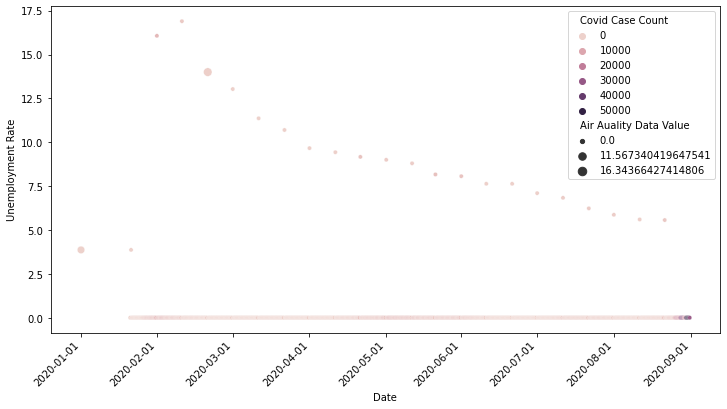

In [111]:
ig, ax = plt.subplots(figsize = (12,6))

fig = sns.scatterplot(data = all_data, 
                      x="Date", 
                      y="Unemployment Rate", 
                      hue="Covid Case Count", 
                      size="Air Auality Data Value", ax=ax)


x_dates = unemployment_rate_df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
arr = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
